# 법원 판결 예측
미국 대법원 사례의 사건의 식별자와 사건의 내용을 담은 데이터셋   
https://dacon.io/competitions/official/236112/overview/description   
참고자료: https://dacon.io/competitions/official/236112/codeshare/8463?page=1&dtype=recent

## 1. 데이터 구조 확인

In [1]:
import pandas as pd
import numpy as np

- ID : 사건 샘플 ID
- first_party : 사건의 첫 번째 당사자
- second_party : 사건의 두 번째 당사자
- facts : 사건 내용
- first_party_winner : 첫 번째 당사자의 승소 여부 (0 : 패배, 1 : 승리)

In [2]:
df_train = pd.read_csv("jud_train.csv")
test = pd.read_csv("jud_test.csv")
df_train.head()

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [3]:
len(df_train)

2478

In [4]:
df_train.duplicated().sum() # 중복값 없음

0

In [5]:
df_train.isnull().sum() # 결측치 없음

ID                    0
first_party           0
second_party          0
facts                 0
first_party_winner    0
dtype: int64

In [6]:
df_train.ID.value_counts() # row마다 unique한 feature --> drop할 예정

TRAIN_0000    1
TRAIN_1654    1
TRAIN_1647    1
TRAIN_1648    1
TRAIN_1649    1
             ..
TRAIN_0827    1
TRAIN_0828    1
TRAIN_0829    1
TRAIN_0830    1
TRAIN_2477    1
Name: ID, Length: 2478, dtype: int64

In [7]:
df_train.first_party.value_counts()

United States       154
Illinois              9
Maryland              8
Florida               8
New York              7
                   ... 
David Carpenter       1
Larry Gene Heath      1
PGA TOUR, Inc.        1
PPL Montana, LLC      1
Markman               1
Name: first_party, Length: 2110, dtype: int64

In [8]:
df_train.first_party_winner.value_counts()

1    1649
0     829
Name: first_party_winner, dtype: int64

In [9]:
# 다운샘플링 --> 오히려 성능이 떨어져서 제거
# from sklearn.utils import resample
# subset_0 = df_train[df_train["first_party_winner"] == 0]
# subset_1 = df_train[df_train["first_party_winner"] == 1]

# subset_1_downsampled = resample(subset_1,
#                                 replace=False,
#                                 n_samples=829,
#                                 random_state=42)

# df_train = pd.concat([subset_0, subset_1_downsampled])

In [10]:
df_train

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1
...,...,...,...,...,...
2473,TRAIN_2473,"HollyFrontier Cheyenne Refining, LLC, et al.","Renewable Fuels Association, et al.",Congress amended the Clean Air Act through the...,1
2474,TRAIN_2474,"Grupo Mexicano de Desarrollo, S. A.","Alliance Bond Fund, Inc.","Alliance Bond Fund, Inc., an investment fund, ...",1
2475,TRAIN_2475,Peguero,United States,"In 1992, the District Court sentenced Manuel D...",0
2476,TRAIN_2476,Immigration and Naturalization Service,St. Cyr,"On March 8, 1996, Enrico St. Cyr, a lawful per...",0


In [11]:
df_train.iloc[0].facts # 판례 내용(텍스트)

'On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.  Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation.  Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.”  Thompson then appealed to the Supreme Court of Louisiana.  That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.  Finally, that court held that the First Amendment protects uninhibited, robust debate, rather t

In [12]:
test.facts[0]

'The 1984 Bail Reform Act allowed the federal courts to detain an arrestee prior to trial if the government could prove that the individual was potentially dangerous to other people in the community. Prosecutors alleged that Salerno and another person in this case were prominent figures in the La Cosa Nostra crime family.\n'

In [13]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def stem_text_func(text):
    token_words=word_tokenize(text) # 단어 단위로 쪼개서 리스트 반환
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter.stem(word)) # 어간화
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [15]:
!pip install stop_words

In [16]:
from stop_words import get_stop_words

# 불용어 리스트
languages = ['English']
my_stop_word_list = []
for i in languages:
  my_stop_word_list.append(get_stop_words(i.lower()))
my_stop_word_list = my_stop_word_list[0] # 2차원을 1차원으로
my_stop_word_list = my_stop_word_list + ['paperbook', 'hardcover'] # 자주 사용된 어휘 추가 제거

len(my_stop_word_list)

176

In [17]:
contractions = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

In [18]:
import re

def preprocessing_sentence(sentence, remove_stopwords = True): # 전처리 단계
    #1. 소문자화
    sentence = sentence.lower()
    #2. 괄호로 닫친 문자열 괄호 제거
    sentence = re.sub(r'\([^)]*\)',' ',sentence)
    #3. 쌍따옴표 제거
    sentence = re.sub('"', ' ', sentence)
    #4. 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    #5. 소유격 제거
    sentence = re.sub(r"'s\b"," ",sentence)
    #6. 특수문자 제거
    sentence = re.sub("[^a-zA-Z]"," ", sentence)

    #불용어 제거
    if my_stop_word_list:
        tokens = ' '.join(word for word in sentence.split() if not word in my_stop_word_list if len(word)>1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word)>1)
    return tokens

In [19]:
df_train['facts'] = [preprocessing_sentence(i) for i in df_train['facts']]
test['facts'] = [preprocessing_sentence(i) for i in test['facts']]

In [20]:
df_train['facts'] = df_train['facts'].astype('str')
test['facts'] = test['facts'].astype('str')

In [21]:
facts_corpus_lose = ' '.join(df_train[df_train['first_party_winner'] == 0]['facts'])
facts_corpus_win = ' '.join(df_train[df_train['first_party_winner'] == 1]['facts'])

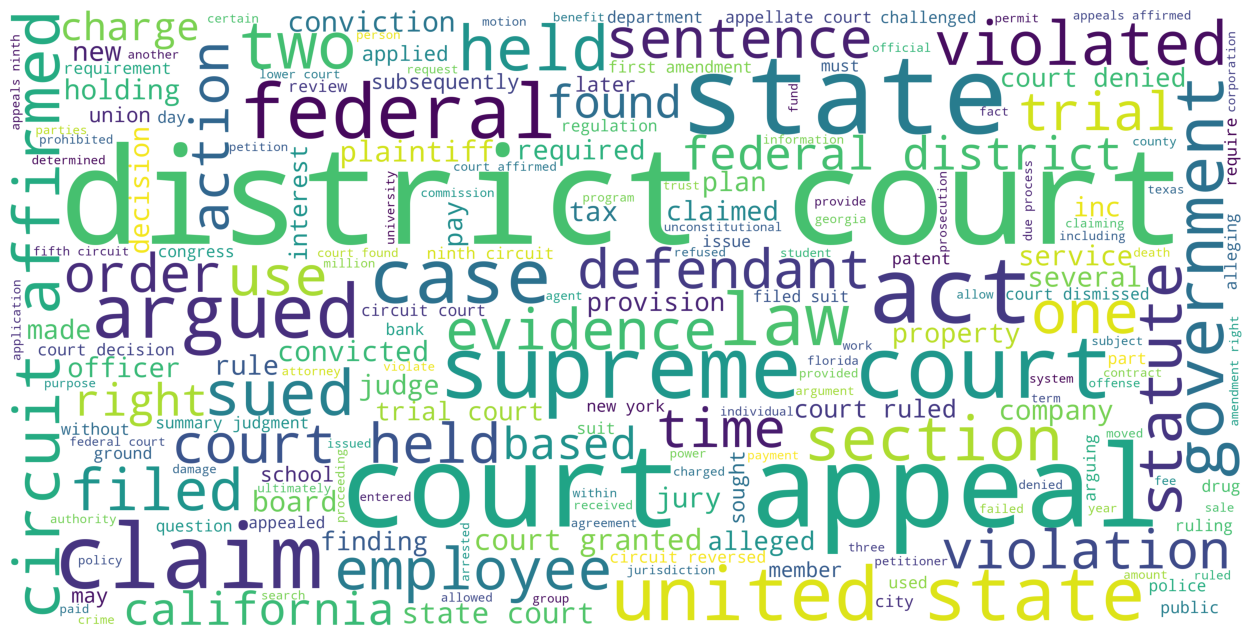

In [22]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

# 패배한 경우 많이 나타난 어휘 목록의 워드 클라우드
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(facts_corpus_lose)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

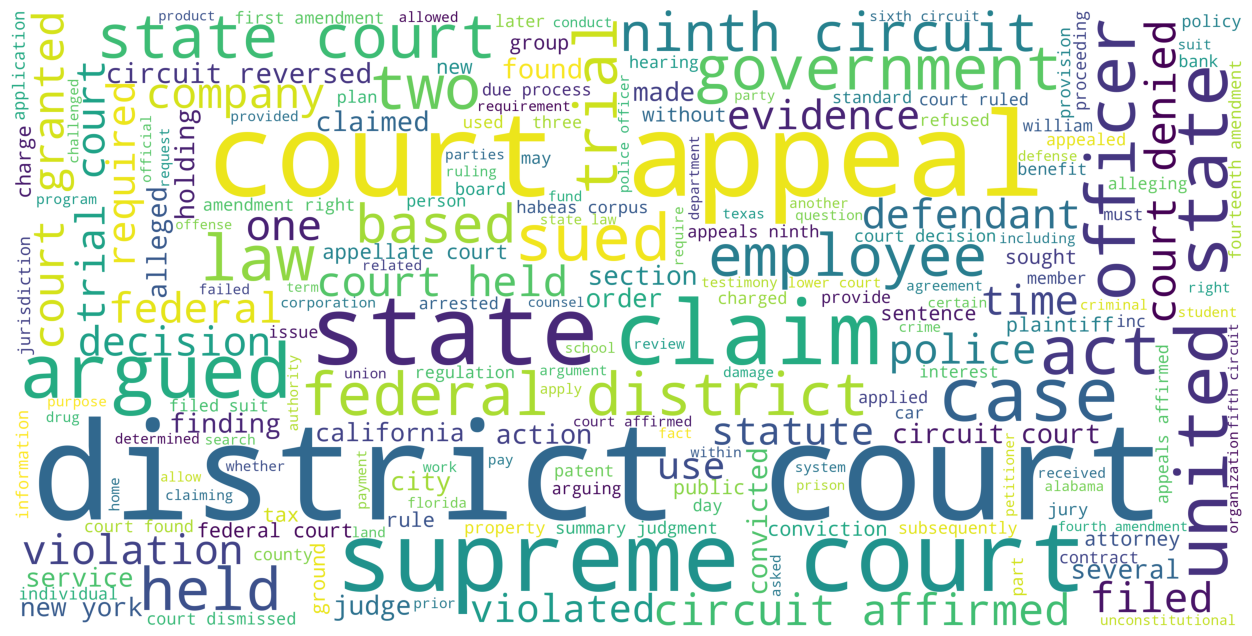

In [23]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

# 승리한 경우 많이 나타난 어휘 목록의 워드 클라우드
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(facts_corpus_win)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])

    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [25]:
X = get_vector(vectorizer, df_train, True)
Y = df_train["first_party_winner"]
X_T = get_vector(vectorizer, test, False)

In [26]:
X = np.squeeze(np.asarray(X))
X_T = np.squeeze(np.asarray(X_T))

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

KNN = KNeighborsClassifier(n_neighbors=200)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)

# 정확도 출력
print("Accuracy:", accuracy_score(y_pred, y_test))

Accuracy: 0.6612903225806451


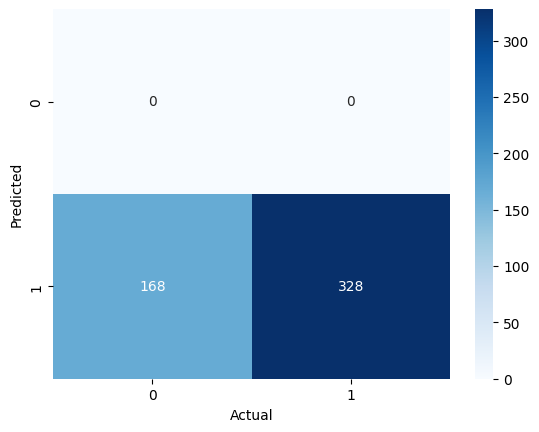

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf = confusion_matrix(y_pred, y_test)
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [34]:
y_test.value_counts()

1    328
0    168
Name: first_party_winner, dtype: int64

다운 샘플링하지 않은 경우
Accuracy: 0.6612903225806451

다운 샘플링한 경우
Accuracy: 0.5933734939759037

법률 텍스트의 경우 대부분 비슷한 성향의 어휘들이 자주 사용되기 때문에 정확도가 잘 나오지 않았다고 생각해볼 수 있을 것 같다   
그리고 오히려 n_neighbors를 늘렸을 때 성능이 올라간 이유는 모두 1로 예측했기 때문이다.   
즉 일반화 성능을 생각했을 때는 다운 샘플링했을 때의 성능인 0.6정도가 베스트일 것으로 예상된다  